# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import warnings
warnings.simplefilter('ignore')
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, InputLayer
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, AveragePooling3D
print(tf.__version__)

2.6.4


# Defining ResNet18 Model

In [2]:
class ConvBlock(Layer):
    def __init__(self, out_channels, kernel_size=(3, 3), stride=1, padding='valid'):
        super(ConvBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(out_channels, kernel_size=kernel_size, strides=stride, padding=padding)
        self.bn = tf.keras.layers.BatchNormalization()
    
    def call(self, input_tensor, training=True):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'conv': self.conv,
            'bn': self.bn
        })
        return config
        
    
class ResBlock(Layer):
    def __init__(self, out_channels, kernel_size=(3, 3), strides=2, padding='same', bn_training=True):
        super(ResBlock, self).__init__()
        self.conv1 = ConvBlock(out_channels=out_channels, kernel_size=kernel_size, stride=strides, padding='valid')
        self.conv2 = ConvBlock(out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same')
        self.conv3 = ConvBlock(out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same')
        self.conv4 = ConvBlock(out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same')
        self.identity_block1 = ConvBlock(out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same')
        self.identity_block2 = self.conv2 = ConvBlock(out_channels=out_channels, kernel_size=kernel_size, stride=1, padding='same')
        
    def call(self, input_tensor, training=True):
        x = self.conv1(input_tensor, training=training)
        x = self.identity_block1(x, training=training)
        x_res = self.conv1(input_tensor, training=training)
        y = tf.keras.layers.Add()([x, x_res])
        x_res = self.identity_block2(y, training=True)
        x = self.conv3(x_res, training=training)
        x = self.conv4(x, training=training)
        x = tf.keras.layers.Add()([x, x_res])
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'conv2': self.conv2,
            'conv3': self.conv3,
            'conv4': self.conv4,
            'identity_block1': self.identity_block1,
            'identity_block2': self.identity_block2
        })
        return config

In [3]:
model = keras.Sequential([
    Conv2D(64, 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    ResBlock(64),
    ResBlock(128),
    ResBlock(256),
    ResBlock(512),
    GlobalAveragePooling2D(),
    Dense(512),
    Dense(2, activation='softmax')
], name='resnet18')

model.build(input_shape=(None, 256, 256, 3))
model.summary()
tf.keras.utils.plot_model(
    model,
    to_file="resnet18_model.jpg",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=1200,
    layer_range=None
)

Model: "resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
res_block (ResBlock)         (None, 126, 126, 64)      185920    
_________________________________________________________________
res_block_1 (ResBlock)       (None, 62, 62, 128)       666752    
_________________________________________________________________
res_block_2 (ResBlock)       (None, 30, 30, 256)       2660608   
_________________________________________________________________
res_block_3 (ResBlock)       (None, 14, 14, 512)       10629632  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0  

# Tensorflow Data Pipeline

In [4]:
img_ds = tf.data.Dataset.list_files('../input/dogs-cats-images/dataset/training_set/*/*', shuffle=True, seed=64)
train_size = int(len(img_ds) * 0.8) #taking 80% of data for training
train_ds = img_ds.take(train_size) #this takes first 80% of data for training
valid_ds = img_ds.skip(train_size) #this skips firat 80% of data and takes next 40% for validation and testing

del train_size, img_ds
train_ds, valid_ds

(<TakeDataset shapes: (), types: tf.string>,
 <SkipDataset shapes: (), types: tf.string>)

In [5]:
def parse_label(label):
    idx = None
    if label == 'cats':
        idx = 0
    else:
        idx = 1
    return tf.one_hot(idx, depth=2)

def create_dataset(file_path):
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label = parse_label(label)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = img / 255.0
    return img, label

train_ds = train_ds.map(create_dataset)
valid_ds = valid_ds.map(create_dataset)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds.batch(32).prefetch(AUTOTUNE)) #.cache()
valid_ds = (valid_ds.batch(32).prefetch(AUTOTUNE)) #.cache()

# Model Compilation & Training

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-03),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['Accuracy']
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    patience=2,
    verbose=0,
    min_lr=1e-07,
    mode='min'
)

es = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=25,
    workers=4,
    use_multiprocessing=True,
    callbacks=[es,reduce_lr,checkpoint],
    shuffle=True,
    verbose=1
)

Epoch 1/25
200/200 [==============================] - 78s 340ms/step - loss: 0.8269 - Accuracy: 0.5081 - val_loss: 1.0021 - val_Accuracy: 0.4938
Epoch 2/25
200/200 [==============================] - 68s 338ms/step - loss: 0.7131 - Accuracy: 0.5211 - val_loss: 0.7360 - val_Accuracy: 0.5125
Epoch 3/25
200/200 [==============================] - 68s 339ms/step - loss: 0.6904 - Accuracy: 0.5659 - val_loss: 0.6659 - val_Accuracy: 0.6131
Epoch 4/25
200/200 [==============================] - 68s 338ms/step - loss: 0.6589 - Accuracy: 0.5992 - val_loss: 0.6872 - val_Accuracy: 0.5888
Epoch 5/25
200/200 [==============================] - 68s 339ms/step - loss: 0.6578 - Accuracy: 0.6127 - val_loss: 0.6763 - val_Accuracy: 0.5806
Epoch 6/25
200/200 [==============================] - 68s 338ms/step - loss: 0.6640 - Accuracy: 0.6008 - val_loss: 0.6662 - val_Accuracy: 0.5994
Epoch 7/25
200/200 [==============================] - 68s 339ms/step - loss: 0.6442 - Accuracy: 0.6317 - val_loss: 0.6334 - val_Ac

# Model Performance Visualization

In [7]:
train_data = {'epochs': [i for i in range(1, (len(history.history['loss']))+ 1)], 'train_loss': history.history['loss'], 'val_loss': history.history['val_loss'], 'train_accuracy':history.history['Accuracy'], 'val_accuracy':history.history['val_Accuracy'], 'lr': history.history['lr']}
train_data = pd.DataFrame(train_data)
train_data.to_csv('train_data.csv', index=False)
display(train_data)

epochs  train_loss  val_loss  train_accuracy  val_accuracy       lr
0        1    0.826923  1.002129        0.508125      0.493750  0.00100
1        2    0.713093  0.735979        0.521094      0.512500  0.00100
2        3    0.690358  0.665940        0.565938      0.613125  0.00100
3        4    0.658919  0.687221        0.599219      0.588750  0.00100
4        5    0.657800  0.676255        0.612656      0.580625  0.00100
5        6    0.664030  0.666195        0.600781      0.599375  0.00090
6        7    0.644158  0.633431        0.631719      0.650625  0.00090
7        8    0.641136  0.629074        0.630000      0.648125  0.00090
8        9    0.629432  0.612418        0.655312      0.663750  0.00090
9       10    0.614452  0.662311        0.671094      0.648125  0.00090
10      11    0.606340  0.590857        0.675469      0.697500  0.00090
11      12    0.599518  0.657891        0.689219      0.621250  0.00090
12      13    0.585652  0.560064        0.694219      0.715000  0.00090
13      14    0.574158  0.585429        0.705625      0.690625  0.00090
14      15    0.563476  0.540084        0.712344      0.737500  0.00090
15      16    0.548152  0.513044        0.730781      0.763750  0.00090
16      17    0.543754  0.580065        0.731094      0.706875  0.00090
17      18    0.540039  0.524859        0.733594      0.740625  0.00090
18      19    0.521706  0.538623        0.744219      0.728750  0.00081
19      20    0.507876  0.506327        0.752031      0.738750  0.00081
20      21    0.496013  0.467913        0.762344      0.777500  0.00081
21      22    0.472448  0.485913        0.775937      0.758125  0.00081
22      23    0.449507  0.428327        0.793437      0.810625  0.00081
23      24    0.433310  0.416138        0.794688      0.812500  0.00081
24      25    0.418183  0.378484        0.807031      0.821250  0.00081

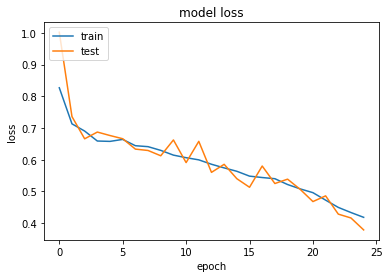

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.jpg', dpi=600)
plt.show()

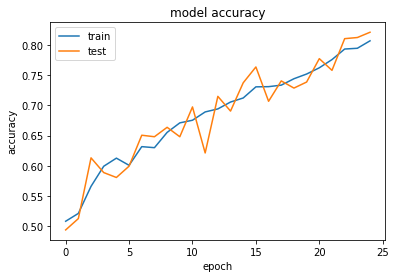

In [9]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.jpg', dpi=600)
plt.show()

# Inference on Test Set

In [10]:
test_ds = tf.data.Dataset.list_files('../input/dogs-cats-images/dataset/test_set/*/*', shuffle=True, seed=64)
test_ds = test_ds.map(create_dataset)
cats = len(os.listdir('../input/dogs-cats-images/dataset/test_set/cats/'))
dogs = len(os.listdir('../input/dogs-cats-images/dataset/test_set/dogs/'))
correct = 0
AUTOTUNE = tf.data.AUTOTUNE
test_ds = (test_ds.batch(1).prefetch(AUTOTUNE)) #.cache()

for img, label in tqdm(test_ds.take(cats + dogs)):
    label = np.argmax(label.numpy().squeeze())
    pred = np.argmax(model.predict(img).squeeze())
    if label==pred:
        correct+=1

accuracy = correct * 100 / (cats + dogs)
print(f'Test Accuracy: {accuracy} %')

  0%|          | 0/2000 [00:00<?, ?it/s]

Test Accuracy: 70.6 %
